# Исходные данные

In [1]:
from graph.graph import graph
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import tqdm

mpl_params = {

    'figure.figsize': (25, 13),
}
plt.rcParams.update(mpl_params)
G = graph.graph

## Палитра цветов
### Палитра узлов

In [2]:
import seaborn

node_palette = seaborn.color_palette('muted', 3)
node_palette

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803)]

### Палитра дуг

In [3]:
edge_palette = seaborn.color_palette('pastel', 3)
edge_palette

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078)]

In [4]:
nodes = G.nodes()
pos = nx.get_node_attributes(G, 'pos')
nodes_types = nx.get_node_attributes(G, 'type')
edges_types = nx.get_edge_attributes(G, 'type')

## Исходный граф
Тип ребер и вершин соответствует типу обслуживаемых беспилотников

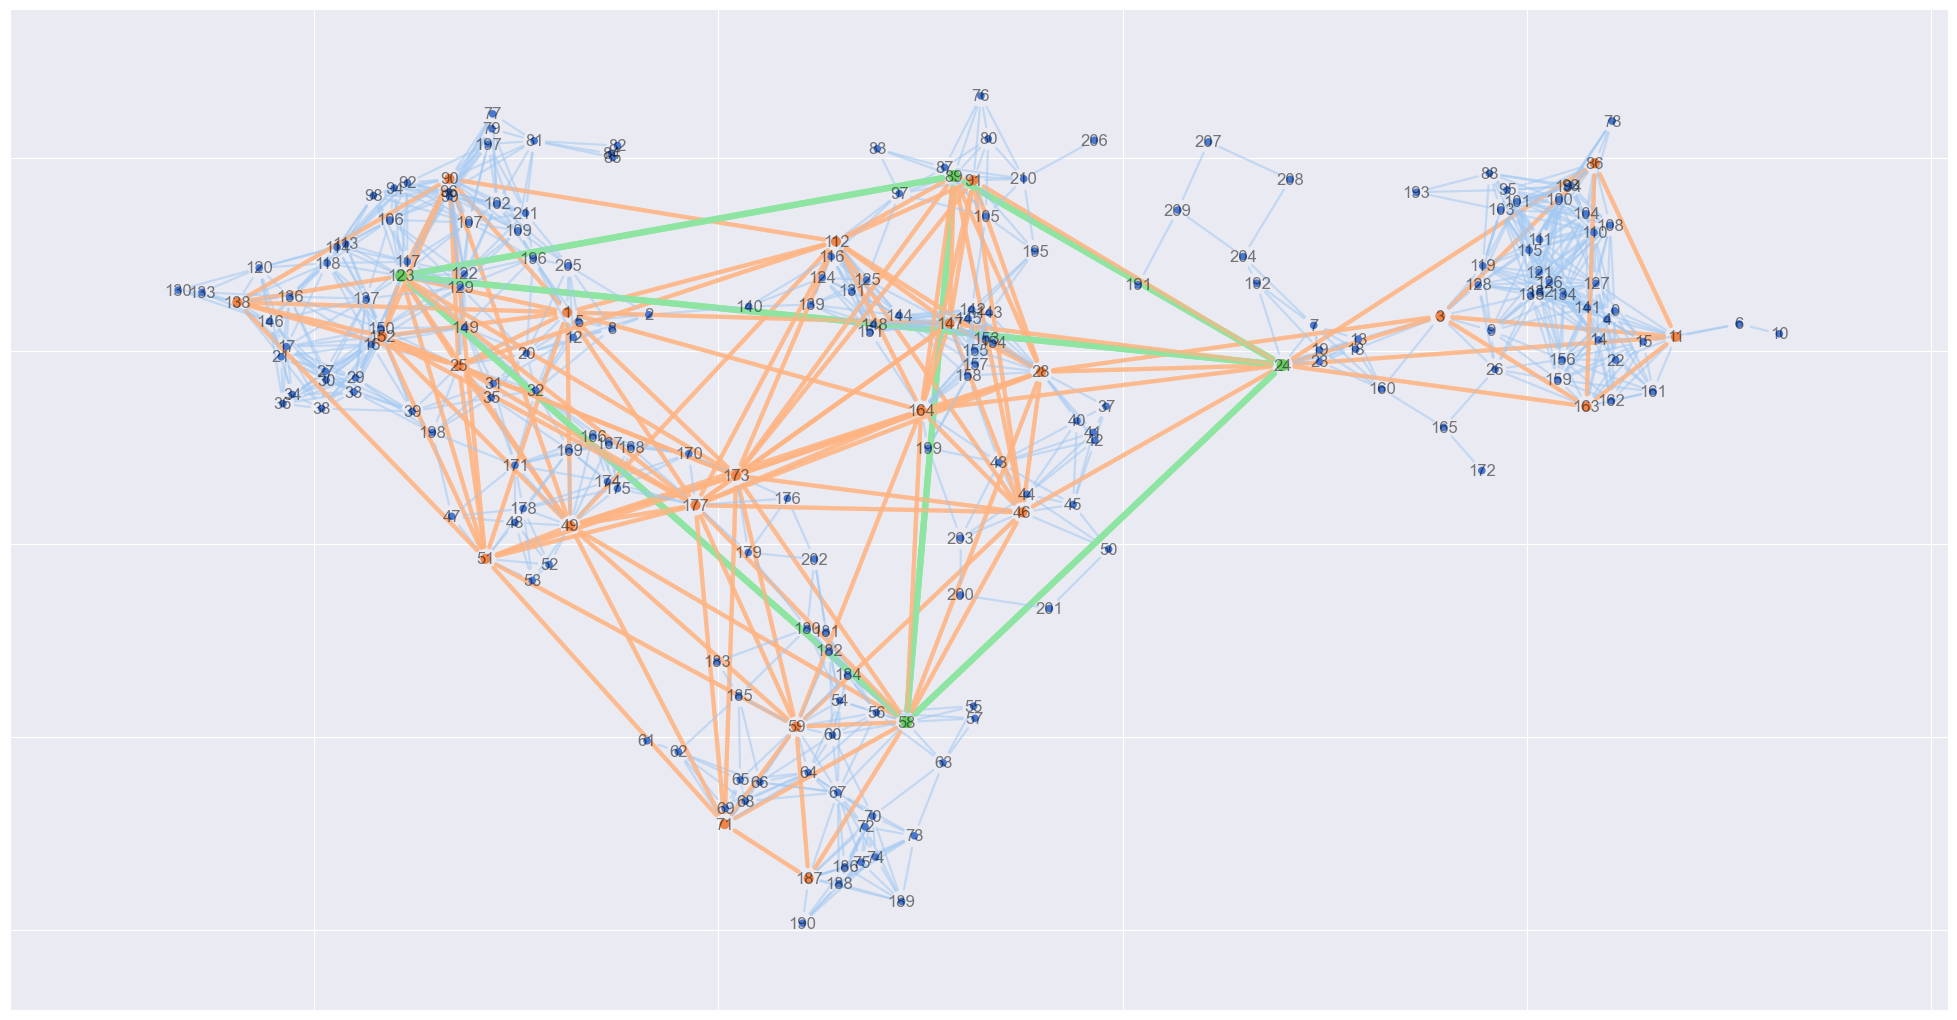

In [5]:
from typing import List

def draw_graph(what: List[str] = None, arrowstyle='-'):
    if what is None or 'edges' in what:
        nx.draw_networkx_edges(G, pos=pos,
                               edge_color=list(map(lambda x: edge_palette[x], edges_types.values())),
                               width=list(map(lambda x: (x + 1) * 1.5, edges_types.values())),
                               alpha=list(map(lambda x: (x + 1) / 3, edges_types.values())),
                               arrows=True,
                               arrowstyle=arrowstyle)
    if what is None or 'nodes' in what:
        nx.draw_networkx_nodes(G, pos=pos,
                               node_color=list(map(lambda x: node_palette[x], nodes_types.values())),
                               node_size=list(map(lambda x: (x + 1) * 20, nodes_types.values())))
    if what is None or 'labels' in what:
        nx.draw_networkx_labels(G, pos=pos,
                                alpha=0.5)


draw_graph()

## Функция стоимости перевозки N грузов на ребрах разных типов
При фиксированном расстоянии

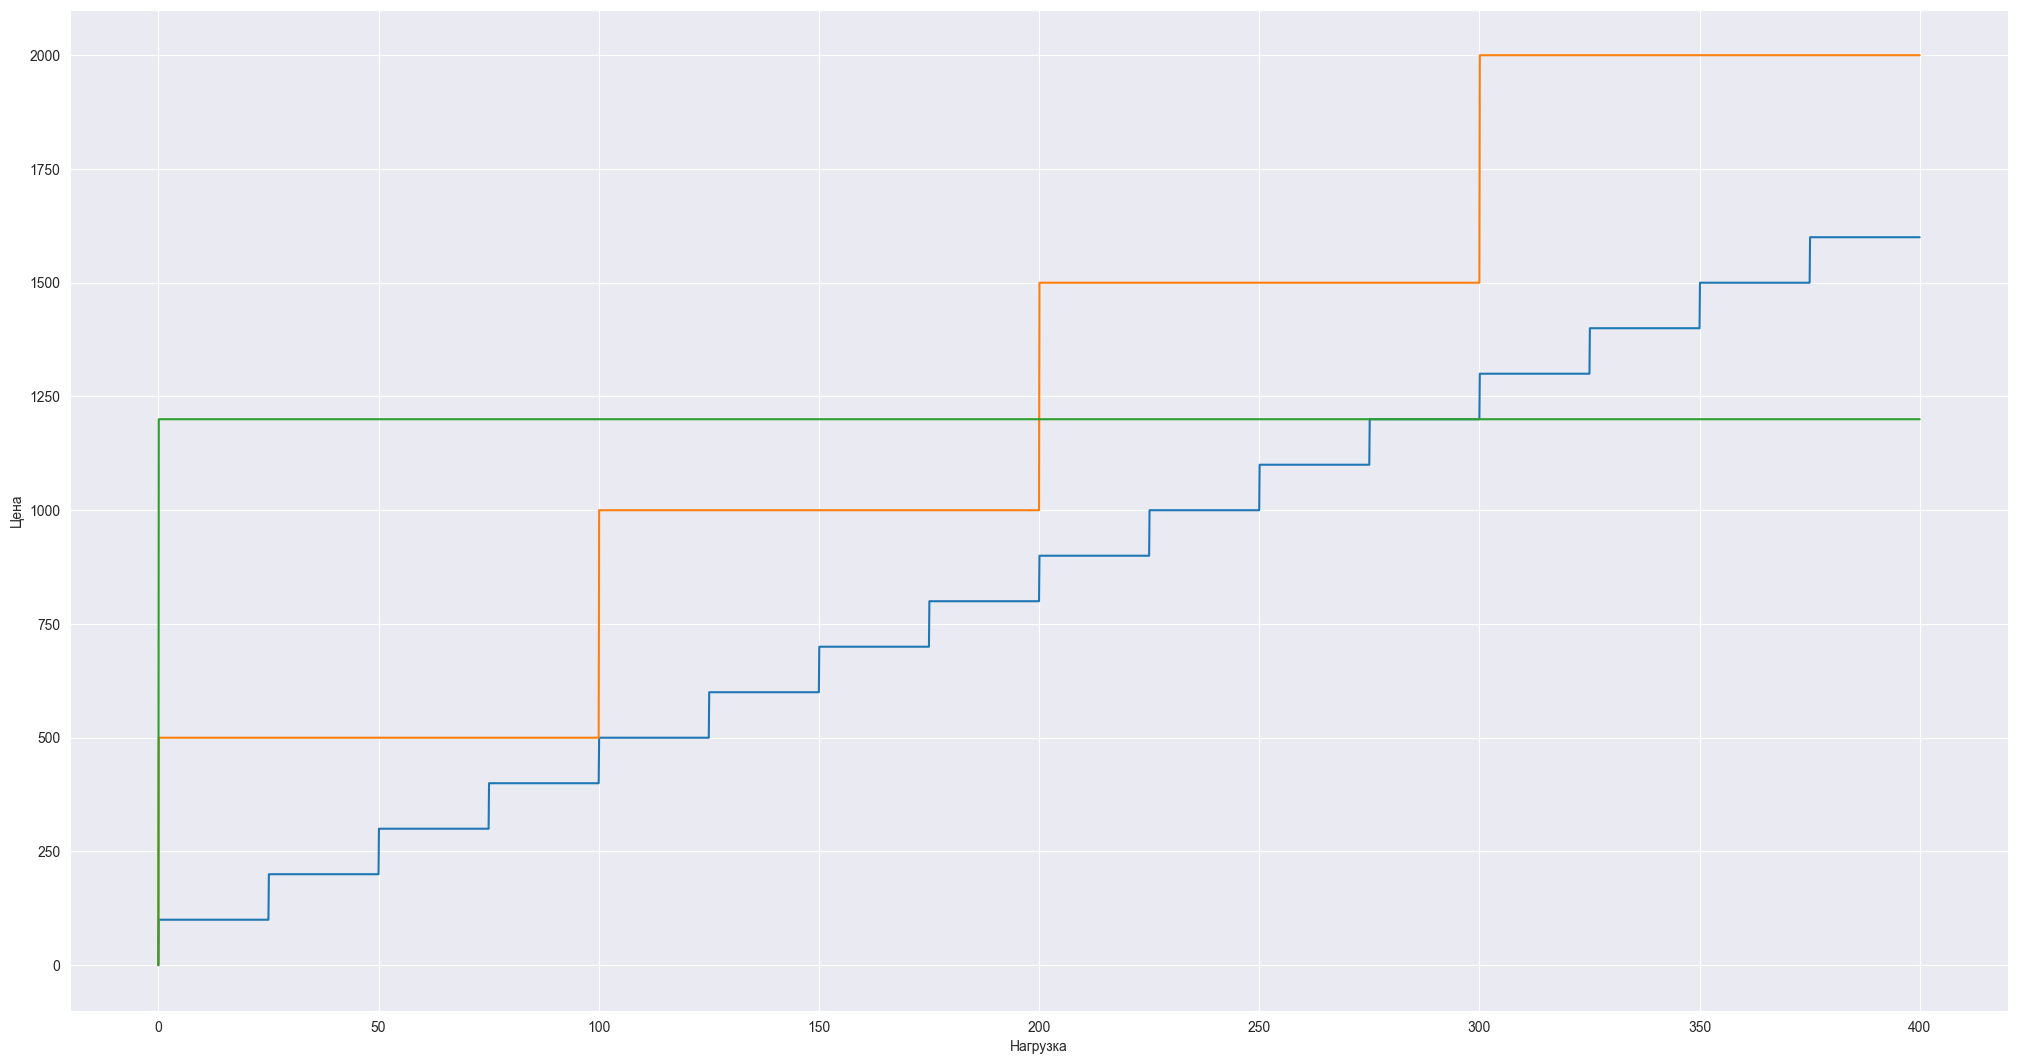

In [6]:
import numpy as np


def draw_price_function(edge_type, dist, max_payload):
    edge_payload = np.arange(-0.01, max_payload, 0.1)
    edge_price = np.array(graph.calc_price(edge_type, dist, edge_payload))
    #
    plt.xlabel('Нагрузка')
    plt.ylabel('Цена')

    plt.plot(edge_payload, edge_price)


draw_price_function(0, 100, 400)
draw_price_function(1, 100, 400)
draw_price_function(2, 100, 400)

## Генерация заказов
А также распределение по размеру партии

(array([1.0737e+04, 1.1946e+04, 8.8130e+03, 4.9610e+03, 2.2670e+03,
        8.2600e+02, 2.7900e+02, 7.2000e+01, 2.4000e+01, 5.0000e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 10 artists>)

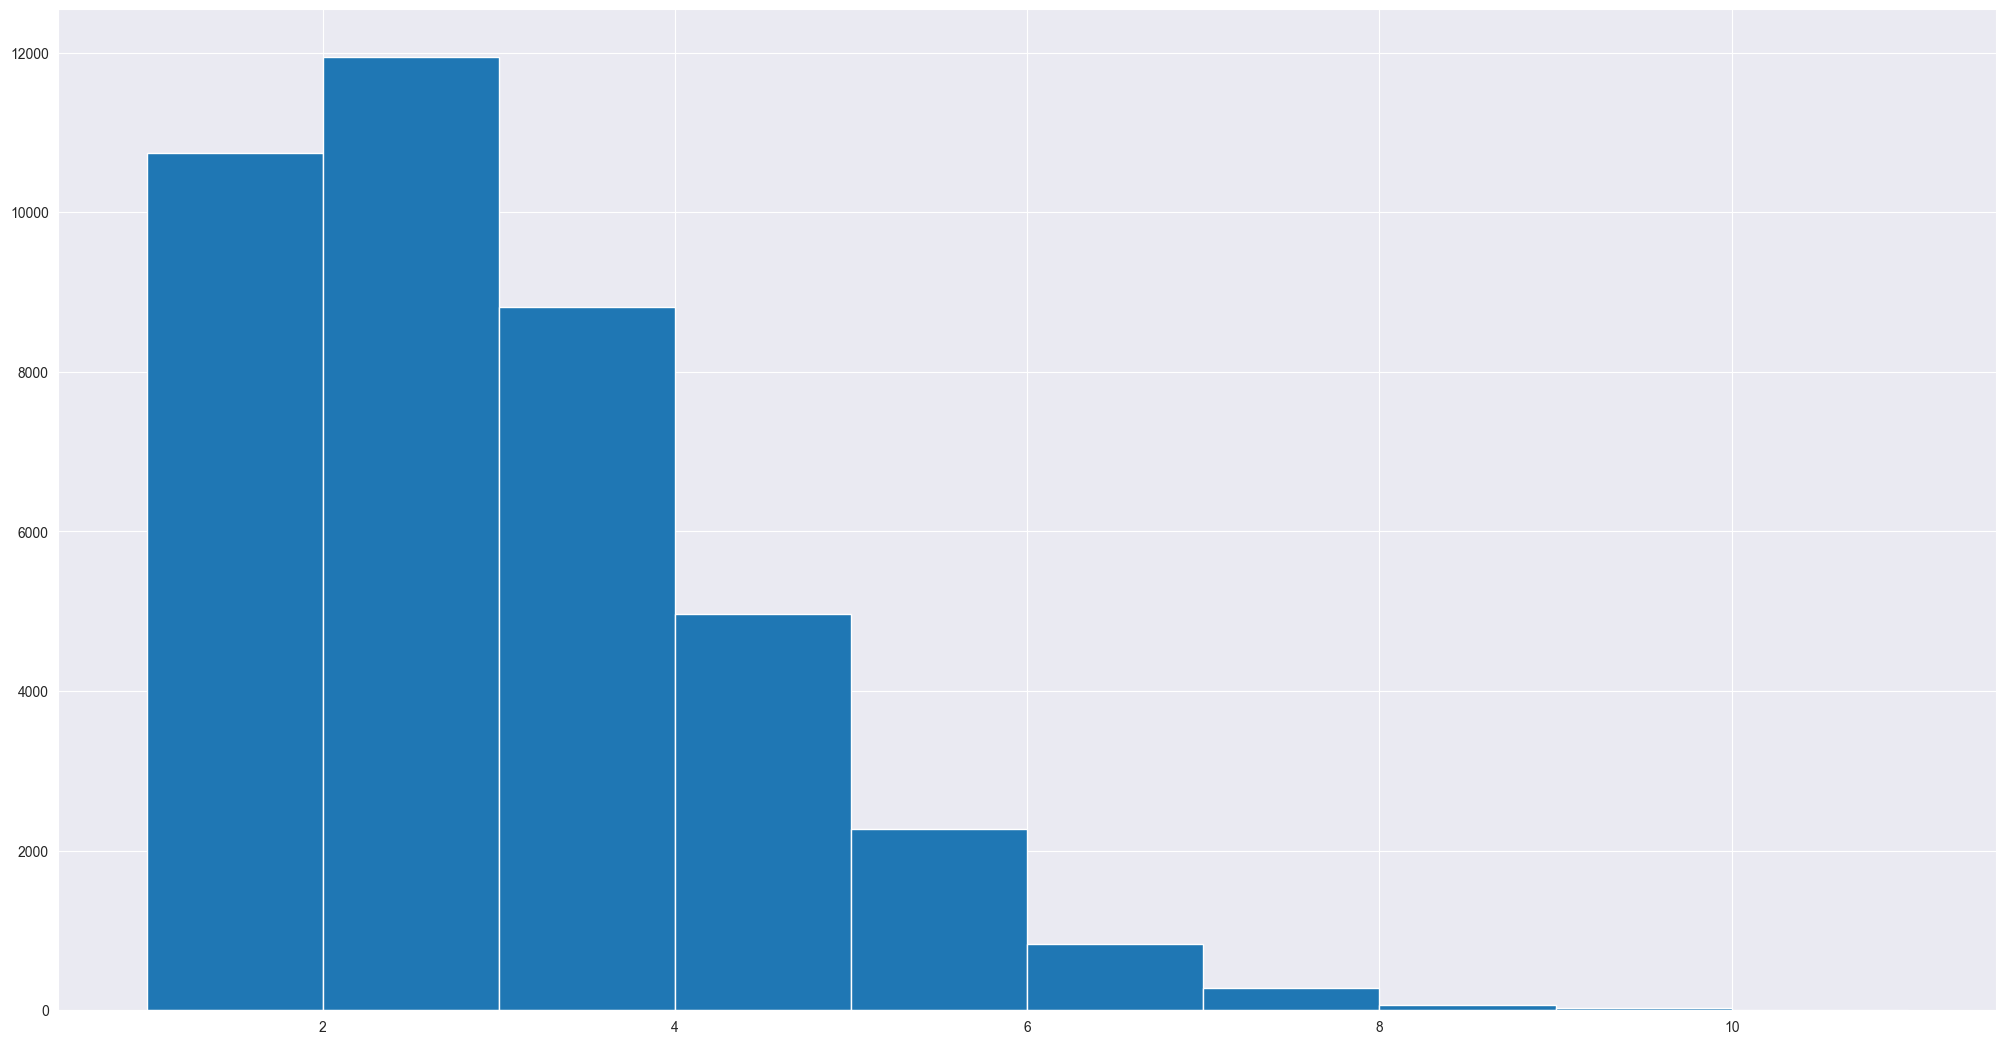

In [7]:
import random
from collections import Counter
random.seed(42)

orders = []
def edges_from_path(p):
    result = []
    for j in range(len(p) - 1):
        result.append((p[j], p[j + 1]))
    return result

for i in range(100000): # 10k
    orders.append(tuple(random.sample(G.nodes(), 2)))
plt.hist(Counter(orders).values())

# Простейший алгоритм планирования путей
Путь для каждого заказа является кратчайшим путем, который формируется на основе априорной информации о длине ребра
## Планирование путей

In [8]:
from itertools import chain
paths = [nx.shortest_path(G, x[0], x[1], 'dist') for x in tqdm(orders)]
used_edges = list(chain(*[edges_from_path(x) for x in tqdm(paths)]))
print('Used edges count: ', len(used_edges))
used_edges_payload = Counter(used_edges)
used_edges_payload

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Used edges count:  498724


Counter({(163, 24): 1077,
         (24, 28): 730,
         (6, 11): 883,
         (11, 24): 1041,
         (24, 58): 2891,
         (58, 63): 850,
         (63, 73): 440,
         (73, 189): 203,
         (70, 67): 444,
         (67, 66): 63,
         (66, 62): 60,
         (57, 58): 428,
         (58, 177): 373,
         (177, 174): 650,
         (174, 169): 214,
         (169, 35): 260,
         (188, 67): 337,
         (67, 58): 1591,
         (58, 24): 2889,
         (24, 3): 8547,
         (3, 26): 414,
         (173, 59): 63,
         (59, 67): 1442,
         (67, 74): 573,
         (74, 189): 167,
         (139, 144): 6087,
         (144, 147): 4808,
         (147, 24): 7455,
         (3, 9): 2320,
         (9, 156): 1602,
         (156, 22): 431,
         (151, 147): 152,
         (3, 128): 3786,
         (128, 115): 2662,
         (115, 108): 384,
         (8, 2): 791,
         (2, 140): 7346,
         (140, 139): 6809,
         (24, 7): 358,
         (23, 24): 1441,
         

## Визуализация нагрузки на каждое ребро
Менее прозрачное - более нагруженное

8623


  0%|          | 0/2339 [00:00<?, ?it/s]

 ...]

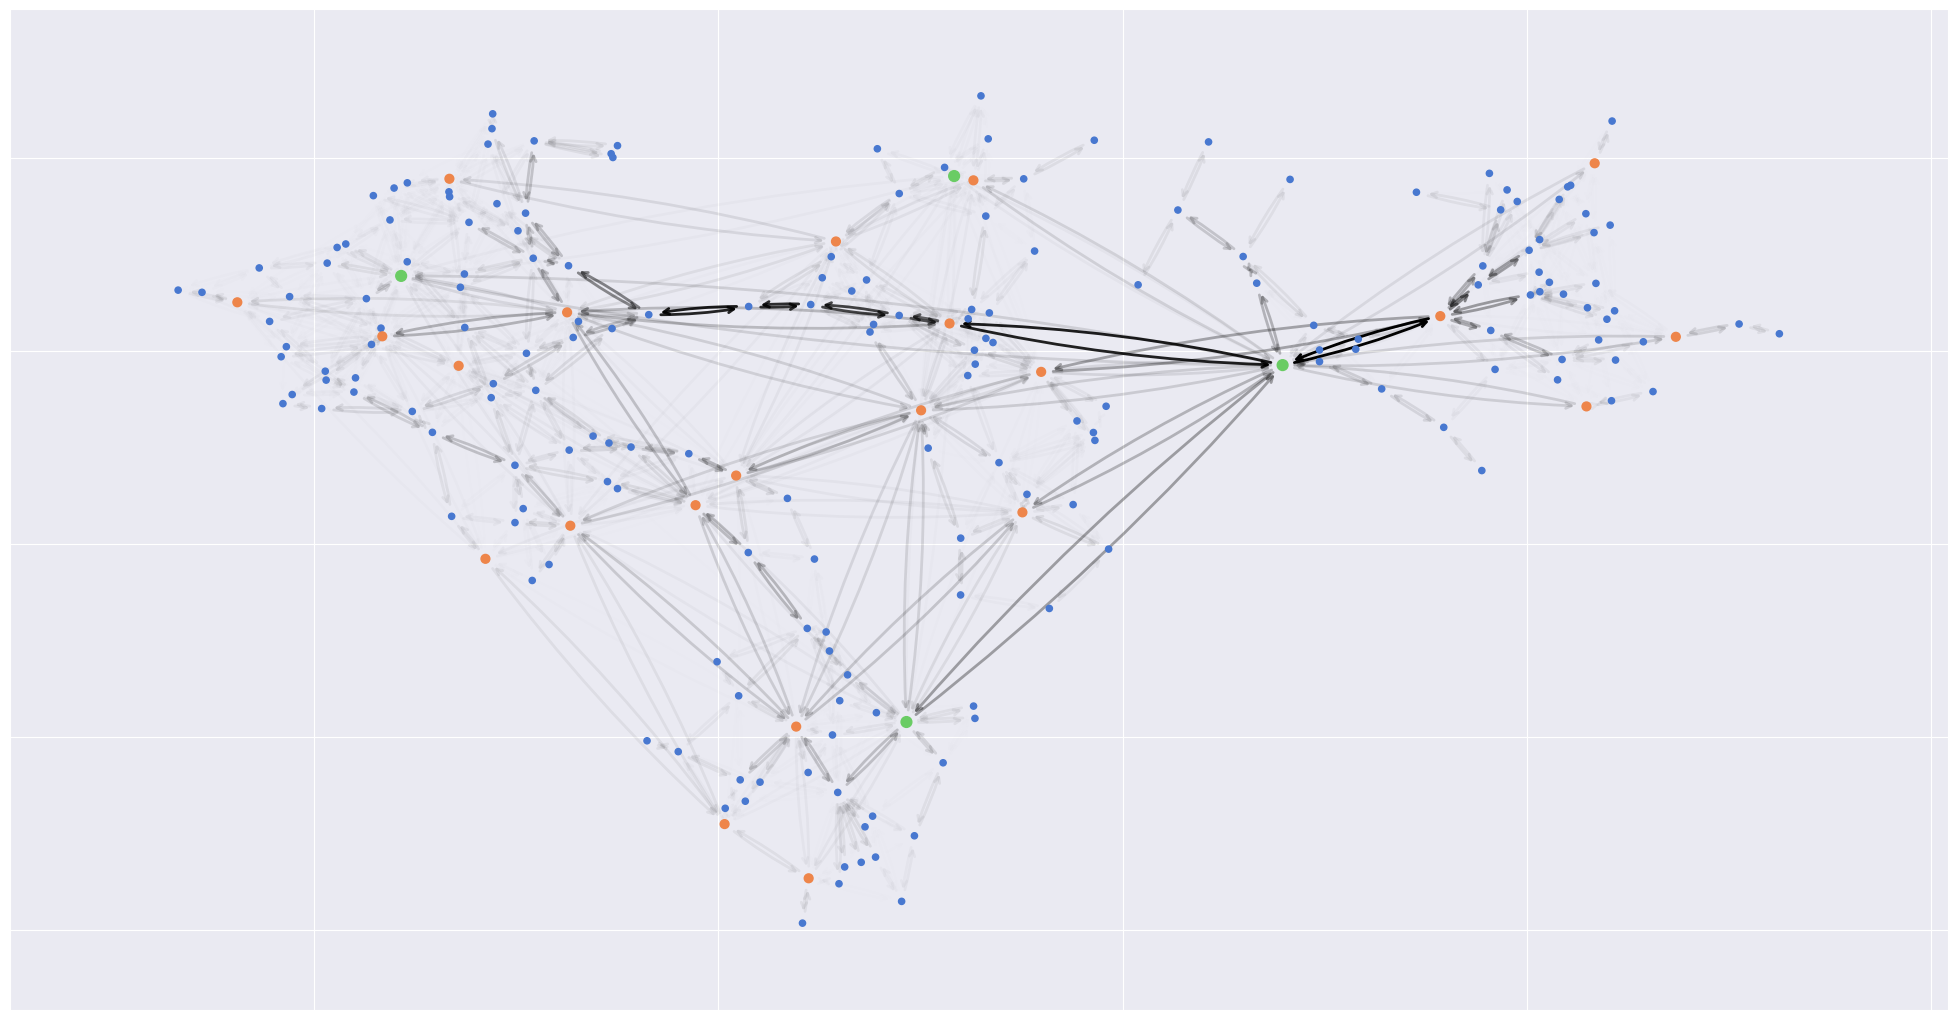

In [9]:
edge_colors = {}
max_edges_payload = max(used_edges_payload.values())
print(max_edges_payload)
for edge, payload in tqdm(used_edges_payload.items()):
    # edge_type = G[edge[0]][edge[1]]['type']
    # edge_colors[edge] = (*node_palette[edge_type], payload / max(used_edges_payload.values()))
    edge_colors[edge] = (0, 0, 0, payload / max_edges_payload)
draw_graph(['nodes'])
nx.draw_networkx_edges(G, pos=pos, arrows=True, width=2, edge_color=edge_colors.values(), edgelist=edge_colors.keys(), connectionstyle='arc3, rad = 0.05', arrowstyle='->')

## Расчет стоимости для данного решения

In [10]:
edge_prices = {}
for edge, payload in tqdm(used_edges_payload.items()):
    edge_attributes = G[edge[0]][edge[1]]
    price = graph.calc_price(edge_attributes['type'], edge_attributes['dist'], payload)
    edge_prices[edge] = price
simplest_algorithm_price = sum(edge_prices.values())
print('Price: ', simplest_algorithm_price)
edge_prices

  0%|          | 0/2339 [00:00<?, ?it/s]

Price:  15328.452045081041


{(163, 24): 83.4885987201243,
 (24, 28): 47.78851142272566,
 (6, 11): 11.51171702223471,
 (11, 24): 107.27884841500637,
 (24, 58): 251.87810080274966,
 (58, 63): 9.744680112759166,
 (63, 73): 7.274364788763376,
 (73, 189): 3.112580615823495,
 (70, 67): 3.8135050806311694,
 (67, 66): 1.1642741429749264,
 (66, 62): 1.3027886436410068,
 (57, 58): 6.107881678618316,
 (58, 177): 30.66730389193017,
 (177, 174): 12.215960455486268,
 (174, 169): 2.2507063891143,
 (169, 35): 5.190584372688687,
 (188, 67): 6.626750304636531,
 (67, 58): 31.915988279230785,
 (58, 24): 251.87810080274966,
 (24, 3): 352.7219547022836,
 (3, 26): 6.574492577378045,
 (173, 59): 6.673812047847902,
 (59, 67): 23.101749482669103,
 (67, 74): 8.828167032855669,
 (74, 189): 1.8425491960867846,
 (139, 144): 107.63337834779702,
 (144, 147): 48.761135844030754,
 (147, 24): 622.9833195248882,
 (3, 9): 24.205214891423523,
 (9, 156): 24.927957622917933,
 (156, 22): 4.761306228336893,
 (151, 147): 2.7725178809162365,
 (3, 128): 37.

# Жадный алгоритм
Рекуррентный алгоритм, где путь для каждого заказа является кратчайшим путем.
Кратчайший путь формируется на основе апостериорной информации о стоимости перелета по ребру.
Стоимость перелета по ребру формируется исходя из нагрузки на ребро
$$ Price=f(Distance, Edgetype, Payload)$$
Нагрузка на ребро формируется на основе информации об уже запланированных заказах и текущем заказе
$$ Payload = \sum_{i=0}^{Current-1}weight_i + weight_{Current}$$
Последовательность планирования путей формируется либо по мере поступления заказов, либо в случайном порядке
## Планирование путей

In [11]:
#fixme модифицировать жадный алгоритм так, чтобы сначала считались просто кратчайшие пути, а затем каждый путь пересчитывался отдельно с учетом фактической стоимости, и путь менялся если стоимость падала
greedy_payload = dict(zip(G.edges, [0] * len(G.edges)))
paths = []
used_edges = []
i = 0
greedy_part = 0.1
for order in tqdm(orders):
    order_prices = {}
    for edge, payload in greedy_payload.items():
        edge_attributes = G[edge[0]][edge[1]]
        predicted_price = graph.calc_price(edge_attributes['type'], edge_attributes['dist'], payload + 1)
        actual_price = graph.calc_price(edge_attributes['type'], edge_attributes['dist'], payload)
        order_price = predicted_price - actual_price
        order_prices[edge] = order_price

    nx.set_edge_attributes(G, order_prices, 'greedy_price')
    path = nx.shortest_path(G, order[0], order[1], 'greedy_price' if i >= (1 - greedy_part) * len(orders) else 'dist')
    paths.append(path)
    path_edges = edges_from_path(path)
    for edge in path_edges:
        greedy_payload[edge] += 1
        used_edges.append(edge)
    i += 1

print('Used edges count: ', len(used_edges))
used_edges_payload = Counter(used_edges)
used_edges_payload


  0%|          | 0/100000 [00:00<?, ?it/s]

Used edges count:  569070


Counter({(163, 24): 999,
         (24, 28): 1708,
         (6, 11): 885,
         (11, 24): 999,
         (24, 58): 2799,
         (58, 63): 869,
         (63, 73): 399,
         (73, 189): 183,
         (70, 67): 549,
         (67, 66): 74,
         (66, 62): 74,
         (57, 58): 374,
         (58, 177): 399,
         (177, 174): 599,
         (174, 169): 224,
         (169, 35): 249,
         (188, 67): 324,
         (67, 58): 1474,
         (58, 24): 2799,
         (24, 3): 7799,
         (3, 26): 399,
         (173, 59): 99,
         (59, 67): 1324,
         (67, 74): 524,
         (74, 189): 149,
         (139, 144): 5499,
         (144, 147): 4571,
         (147, 24): 6799,
         (3, 9): 2099,
         (9, 156): 1449,
         (156, 22): 385,
         (151, 147): 149,
         (3, 128): 3609,
         (128, 115): 2424,
         (115, 108): 349,
         (8, 2): 921,
         (2, 140): 7050,
         (140, 139): 6577,
         (24, 7): 349,
         (23, 24): 2792,
         (

## Визуализация нагрузки на каждое ребро

7799


  0%|          | 0/2382 [00:00<?, ?it/s]

 ...]

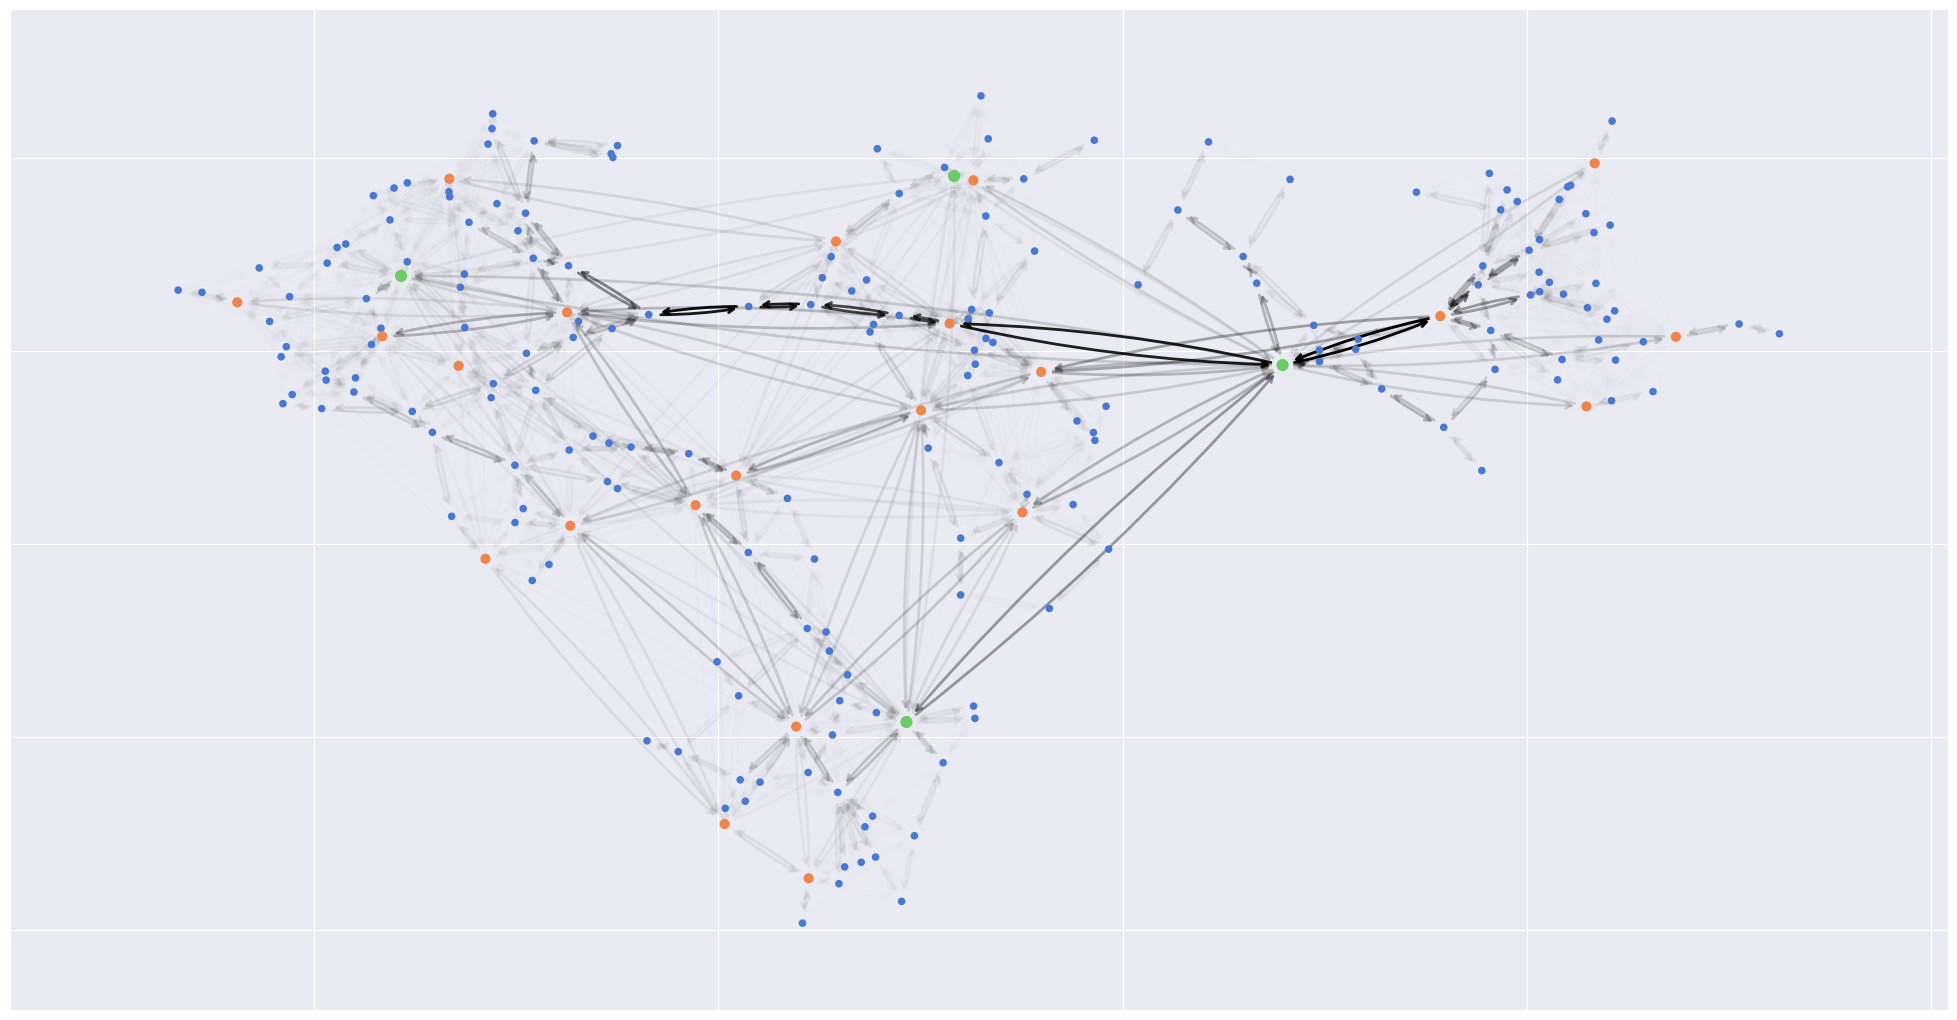

In [12]:
edge_colors = {}
max_edges_payload = max(used_edges_payload.values())
print(max_edges_payload)
for edge, payload in tqdm(used_edges_payload.items()):
    # edge_type = G[edge[0]][edge[1]]['type']
    # edge_colors[edge] = (*node_palette[edge_type], payload / max(used_edges_payload.values()))
    edge_colors[edge] = (0, 0, 0, payload / max_edges_payload)
draw_graph(['nodes'])
nx.draw_networkx_edges(G, pos=pos, arrows=True, width=2, edge_color=edge_colors.values(), edgelist=edge_colors.keys(), connectionstyle='arc3, rad = 0.05', arrowstyle='->')

## Расчет стоимости для данного решения

In [13]:
edge_prices = {}
for edge, payload in tqdm(used_edges_payload.items()):
    edge_attributes = G[edge[0]][edge[1]]
    price = graph.calc_price(edge_attributes['type'], edge_attributes['dist'], payload)
    edge_prices[edge] = price
greedy_algorithm_price = sum(edge_prices.values())
print('Price: ', greedy_algorithm_price)
edge_prices

  0%|          | 0/2382 [00:00<?, ?it/s]

Price:  14733.225238490842


{(163, 24): 75.89872610920392,
 (24, 28): 107.52415070113274,
 (6, 11): 11.51171702223471,
 (11, 24): 97.52622583182398,
 (24, 58): 220.39333820240594,
 (58, 63): 9.744680112759166,
 (63, 73): 6.466102034456334,
 (73, 189): 2.76673832517644,
 (70, 67): 4.660950654104762,
 (67, 66): 1.1642741429749264,
 (66, 62): 1.3027886436410068,
 (57, 58): 5.089901398848597,
 (58, 177): 30.66730389193017,
 (177, 174): 10.858631515987796,
 (174, 169): 2.2507063891143,
 (169, 35): 4.718713066080625,
 (188, 67): 6.153410997162493,
 (67, 58): 29.422551694915878,
 (58, 24): 220.39333820240594,
 (24, 3): 319.91061007881535,
 (3, 26): 6.187757719885219,
 (173, 59): 6.673812047847902,
 (59, 67): 21.110219354852802,
 (67, 74): 8.06050033434648,
 (74, 189): 1.5793278823601011,
 (139, 144): 97.04648867424321,
 (144, 147): 46.23465212154211,
 (147, 24): 564.8382097025652,
 (3, 9): 21.862774740640603,
 (9, 156): 22.24340834044985,
 (156, 22): 4.232272202966127,
 (151, 147): 2.376443897928203,
 (3, 128): 35.92965

# Генетический алгоритм

##  K кратчайших путей
Для примера - между вершинами 10 и 130
Красным отмечен кратчайший путь

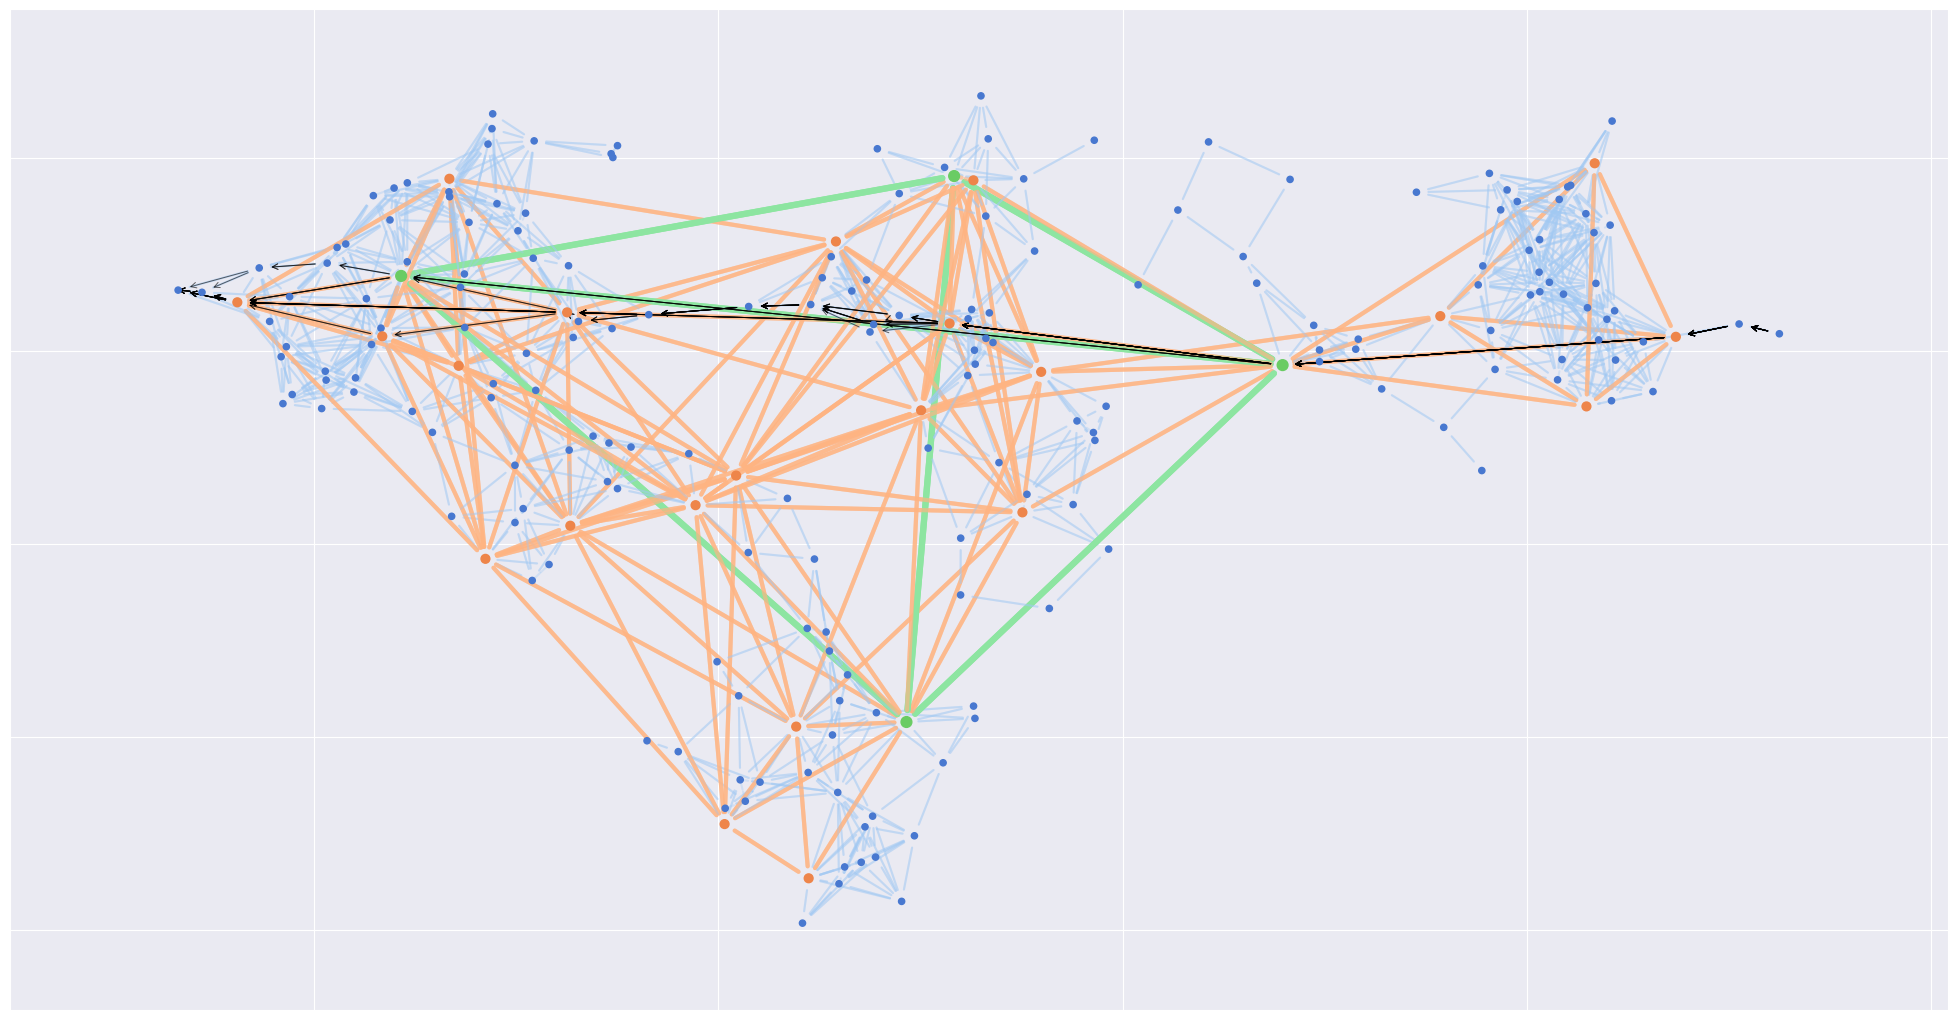

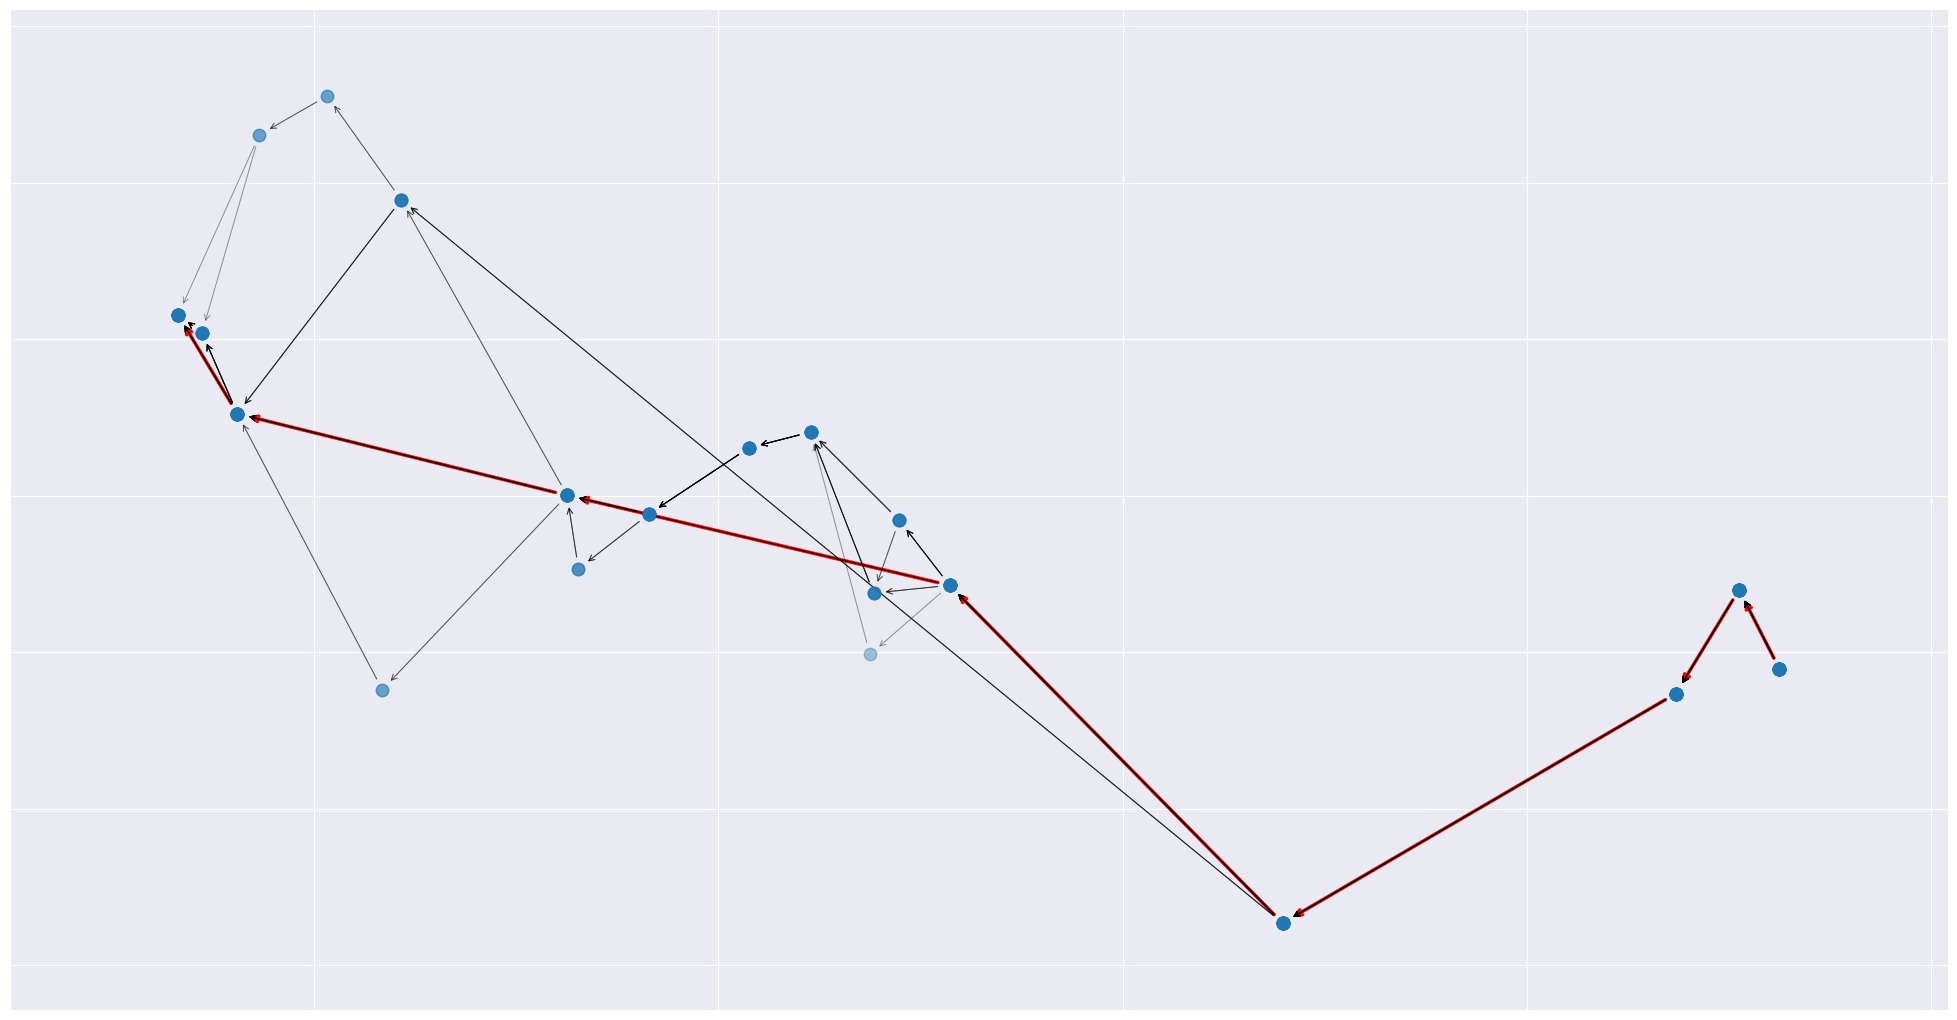

In [14]:

from logistics.k_shortest import k_shortest



paths = k_shortest(G, 10, 130, 'dist')
plt.figure(1)
draw_graph(['nodes', 'edges'])
for path in paths:
    nx.draw_networkx_edges(G, pos=pos, edgelist=edges_from_path(path), alpha=0.6, arrows=True, arrowstyle='->', width=0.7)
plt.figure(2)
for i, path in enumerate(paths):
    nx.draw_networkx_edges(G, pos=pos, edgelist=edges_from_path(path), alpha=1 if i == 0 else 0.4,
                           arrows=True, arrowstyle='->', width=2.5 if i == 0 else 0.7, edge_color='red' if i == 0 else 'k')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=path, alpha=0.4, node_size=80)
    # nx.draw_networkx_labels(G, pos=pos, labels=dict(zip(path, path)), horizontalalignment='left')

## Пространство генов

In [15]:
gene_space = []
for order in tqdm(orders):
    gene_space.append(k_shortest(G, order[0], order[1], 'dist'))

  0%|          | 0/100000 [00:00<?, ?it/s]

## Функция пригодности

In [16]:
def fitness_function(solution, _):
    all_edges = []
    for order_index, order_path_number in enumerate(solution):
        order_path = gene_space[order_index][order_path_number]
        order_edges = edges_from_path(order_path)
        [all_edges.append(x) for x in order_edges]
    all_edges_payload = Counter(all_edges)
    all_edges_prices = {}
    for ed, ed_payload in all_edges_payload.items():
        ed_attributes = G[ed[0]][ed[1]]
        all_edges_prices[ed] = graph.calc_price(ed_attributes['type'], ed_attributes['dist'], ed_payload)
    return 1 / sum(all_edges_prices.values())

In [17]:
import pygad

num_generations = 120
num_parents_mating = 7
sol_per_pop = 50
# num_genes = len(orders)

population = [[0] * len(orders)]
for i in range(sol_per_pop):
    individual = []
    for gene in gene_space:
        individual.append(random.sample(list(range(len(gene))), 1)[0])
    population.append(individual)

last_fitness = 0
def callback_generation(ga_inst):
    global last_fitness
    print("Generation = {generation}".format(generation=ga_inst.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_inst.best_solution()[1]))
    # print("Change     = {change}".format(change=ga_inst.best_solution()[1] - last_fitness))
    print('-----------------------------------')
    last_fitness = ga_instance.best_solution()[1]

gene_space_numeric = list(map(lambda x: list(range(len(x))), gene_space))
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       initial_population=population,
                       on_generation=callback_generation,
                       gene_space=gene_space_numeric,
                       gene_type=int)

Generation = 1
Fitness    = 6.547025864686042e-05
-----------------------------------
Generation = 2
Fitness    = 6.547025864686042e-05
-----------------------------------
Generation = 3
Fitness    = 6.550237760065971e-05
-----------------------------------
Generation = 4
Fitness    = 6.558595017710936e-05
-----------------------------------
Generation = 5
Fitness    = 6.558595017710936e-05
-----------------------------------
Generation = 6
Fitness    = 6.558595017710936e-05
-----------------------------------
Generation = 7
Fitness    = 6.558595017710936e-05
-----------------------------------
Generation = 8
Fitness    = 6.558595017710936e-05
-----------------------------------
Generation = 9
Fitness    = 6.558595017710936e-05
-----------------------------------
Generation = 10
Fitness    = 6.558595017710936e-05
-----------------------------------
Generation = 11
Fitness    = 6.558595017710936e-05
-----------------------------------
Generation = 12
Fitness    = 6.558595017710936e-05
-

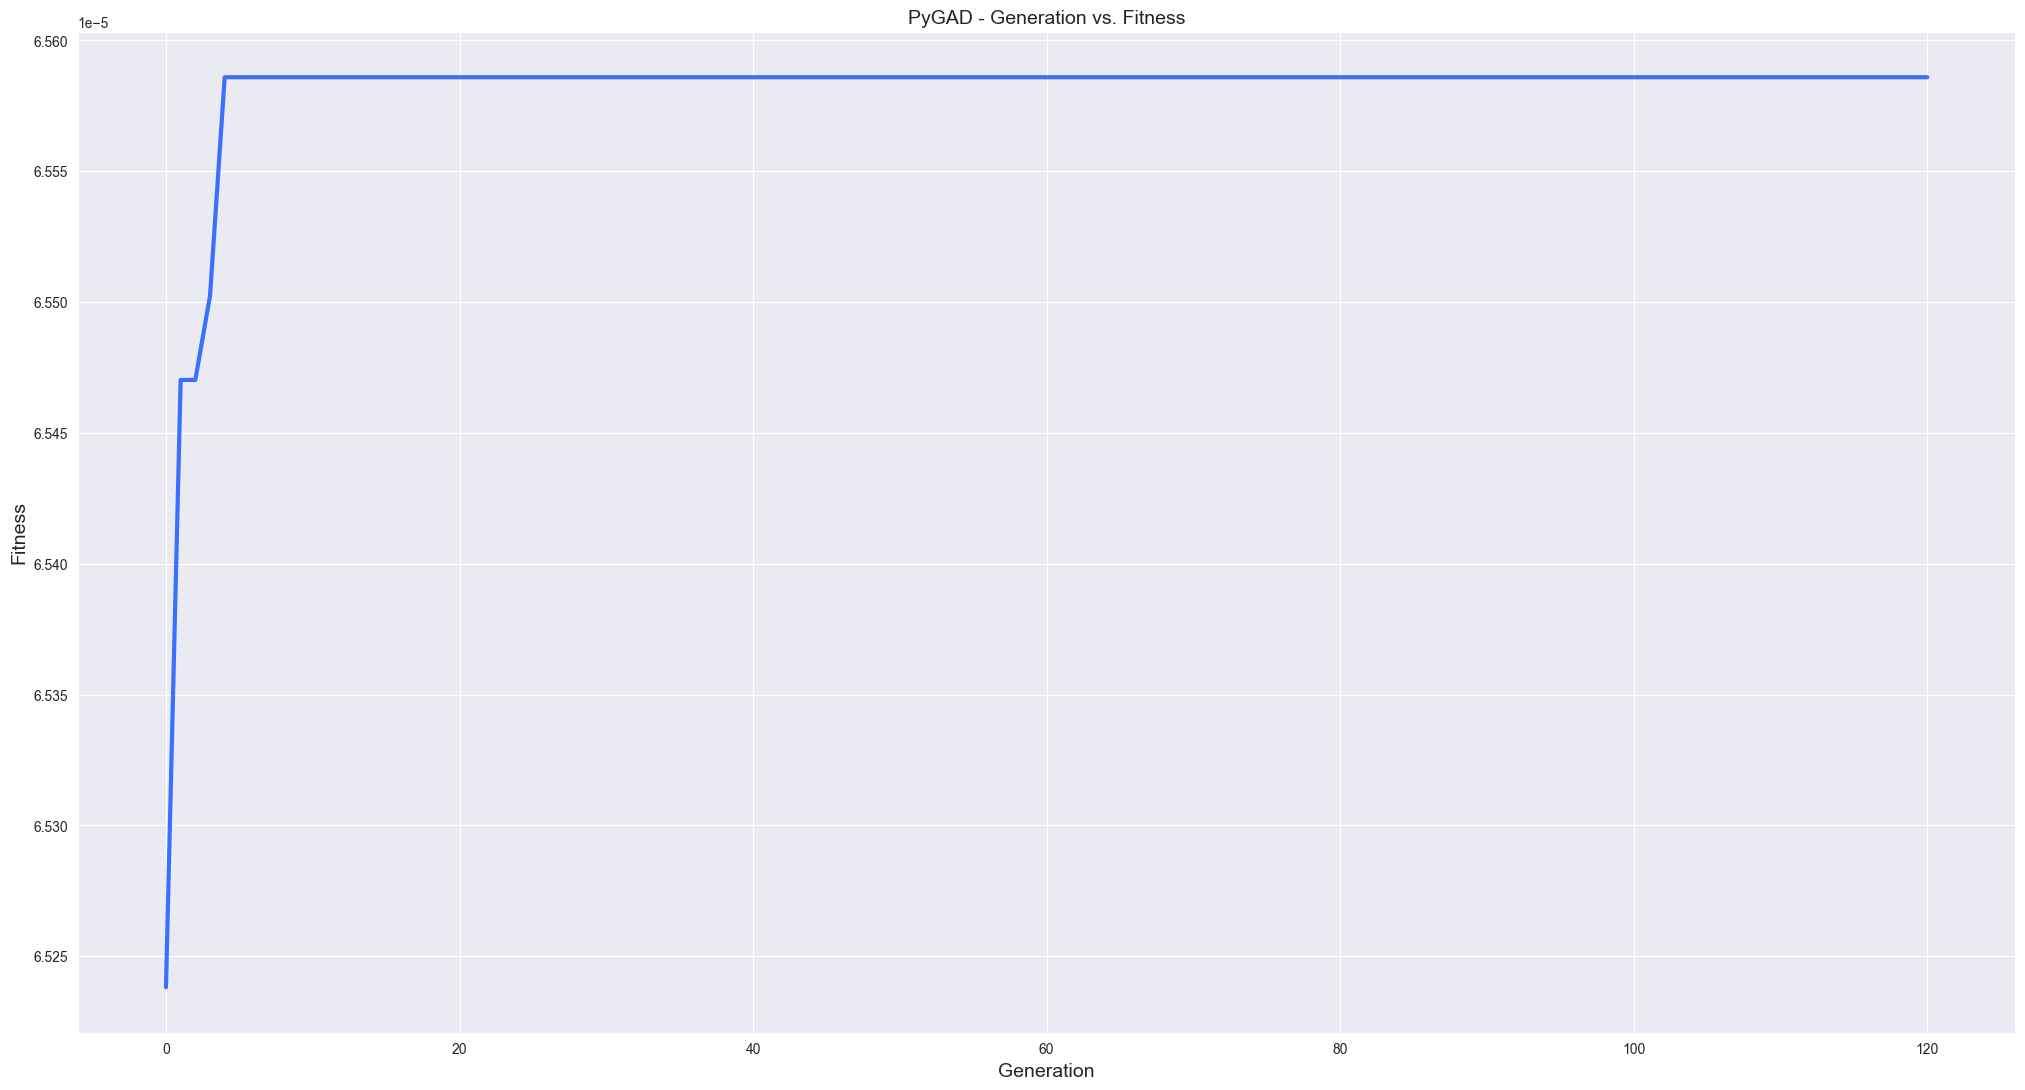

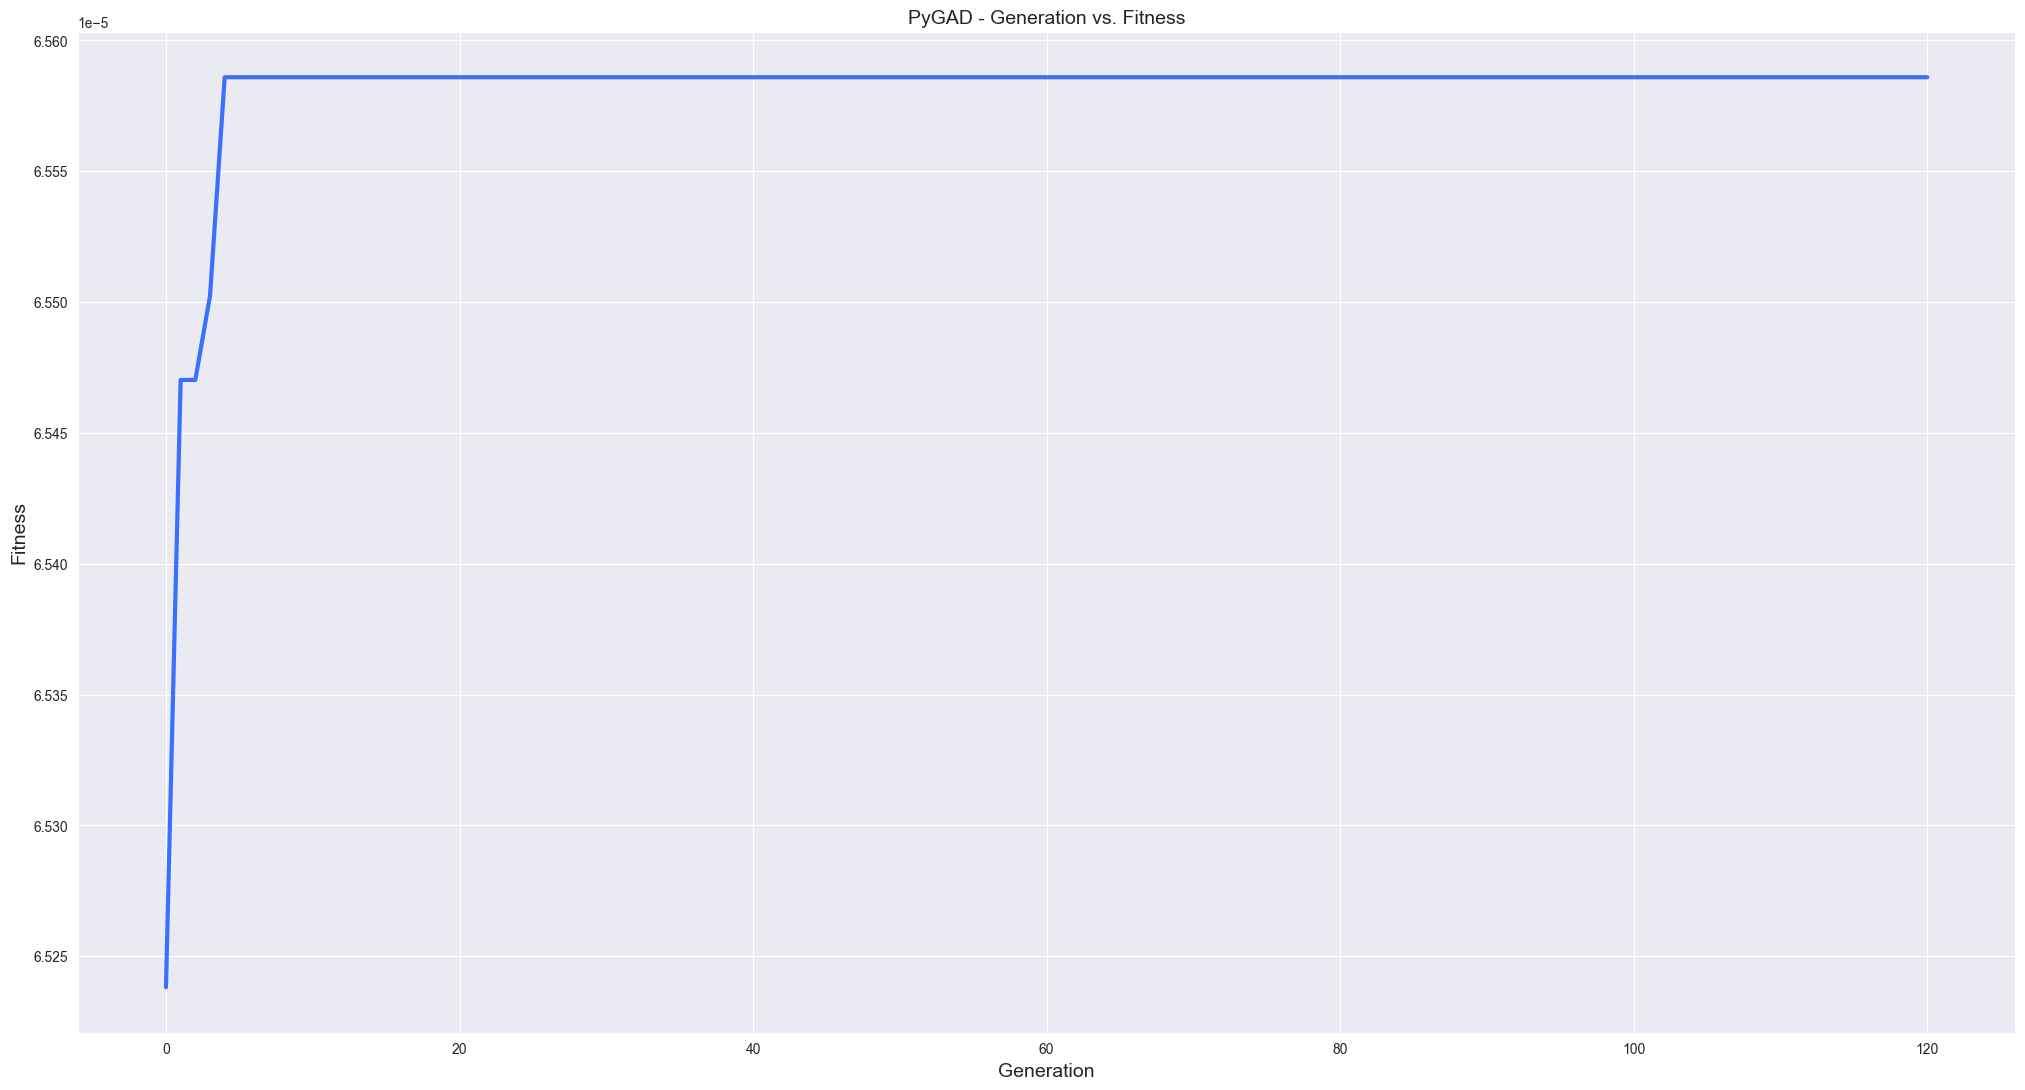

In [18]:
ga_instance.run()
ga_instance.plot_fitness()

## Расчет стоимости для данного решения

In [19]:
1 / ga_instance.best_solution()[1]

15247.16798795449